In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plti
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree

from  ana_tools import *


plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6],
                     'legend.frameon': True
                     })

anatree:Anatree

In [2]:
anatree = Anatree("/home/henrique/Documents/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/anatree_hd_AV_2dot5_random_sum_300k_new.root", entry_start=0, entry_stop=1000, load_data=False)
anatree.tree:uproot.TTree
anatree.read_parquet('../../../../../data/atm_50k_hd_AV_2.5_random/parquet_new/',batches=-1, concat=False)#, types=['nu','reco_tracks','reco_showers'])#, n_rows=100)

Reading nu files... 30/30
Reading geant files... 30/30
Reading reco_tracks files... 30/30
Reading reco_showers files... 30/30
Reading pfp files... 30/30


In [3]:
nu = anatree.nu
geant = anatree.geant
shw = anatree.reco_showers
tracks = anatree.reco_tracks
showers = anatree.reco_showers
merged:pl.DataFrame
merged = 0
merged = pl.read_parquet('/home/henrique/Documents/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/reco_geant_nu.pasquet')
# for i,n in enumerate(nu):
#     df = anatree.get_full_reco_tracks(tracks[i], geant[i], nu[i])
#     df = df.collect()
#     if i == 0:
#         merged = df
#     else:
#         merged = pl.concat([merged,df])

In [4]:
geant_nu:pl.DataFrame
geant_nu = 0
nu = merge_same_df(anatree.nu)
dfnu = nu.filter((pl.col('ccnc_truth')==0) & (pl.col('nuPDG_truth').abs()==14))
def geant_mothers():
   return pl.col('Mother_geant')==0

geant_nu = merge_same_df(anatree.geant, filter_function=geant_mothers, df_concat=dfnu, left_on=['subrun','event'], right_on=['subrun','event'], how='inner')

In [5]:
df:pl.DataFrame
nu:pl.DataFrame
pfp:pl.DataFrame
geant_nu:pl.DataFrame
df = merged
pfp = merge_same_df(anatree.pfp)
# nu = merge_same_df(anatree.nu)


In [6]:
df = merged.filter(
    pl.col('has_valid_pfp') == 1
)
df = df.with_columns(
    track_angle_diff = ((pl.col('trkstartdcosx_pandoraTrack')*pl.col('Px_geant') +
                         pl.col('trkstartdcosy_pandoraTrack')*pl.col('Py_geant') +
                         pl.col('trkstartdcosz_pandoraTrack')*pl.col('Pz_geant'))/pl.col('P_geant')).arccos()*180/np.pi,
    zenith_reco = pl.col('trkstartdcosy_pandoraTrack').arccos()*180/np.pi,
    zenith_geant = (pl.col('Py_geant')/pl.col('P_geant')).arccos()*180/np.pi,
    zenith_truth = pl.col('nu_dcosy_truth').arccos()*180/np.pi,
).with_columns(
    zenith_g_diff = pl.col('zenith_reco')- pl.col('zenith_geant')
)

In [7]:
geant_nu_f = geant_nu.with_columns(
    zenith_truth = (pl.col('nu_dcosy_truth')).arccos()*180/np.pi,
)
g_only_mu = geant_nu_f.filter(pl.col('pdg_geant').abs()==13).group_by(selection_events()).agg(
    pl.col('^*_truth$').first(),
    zenith_final = (pl.col('Py_geant').first()/pl.col('P_geant').first()).arccos()*180/np.pi,
).with_columns(
    zenith_diff = pl.col('zenith_final')- pl.col('zenith_truth')
)

g_all_particles = geant_nu_f.group_by(selection_events()).agg(
        pl.col('^*_truth$').first(),
        total_px = pl.col('Px_geant').sum(),
        total_py = pl.col('Py_geant').sum(),
        total_pz = pl.col('Pz_geant').sum(),
    ).with_columns(
        zenith_final = ( pl.col('total_py')/(pl.col('total_px')**2 + pl.col('total_py')**2 + pl.col('total_pz')**2).sqrt() ).arccos()*180/np.pi,
    ).with_columns(
        zenith_diff = pl.col('zenith_final')- pl.col('zenith_truth')
    )


g_all_minus_n = geant_nu_f.filter(
        pl.col('pdg_geant')!=2112
    ).group_by(selection_events()).agg(
        pl.col('^*_truth$').first(),
        total_px = pl.col('Px_geant').sum(),
        total_py = pl.col('Py_geant').sum(),
        total_pz = pl.col('Pz_geant').sum(),
    ).with_columns(
        zenith_final = ( pl.col('total_py')/(pl.col('total_px')**2 + pl.col('total_py')**2 + pl.col('total_pz')**2).sqrt() ).arccos()*180/np.pi,
    ).with_columns(
        zenith_diff = pl.col('zenith_final')- pl.col('zenith_truth')
    )

['subrun', 'event']
['subrun', 'event']
['subrun', 'event']


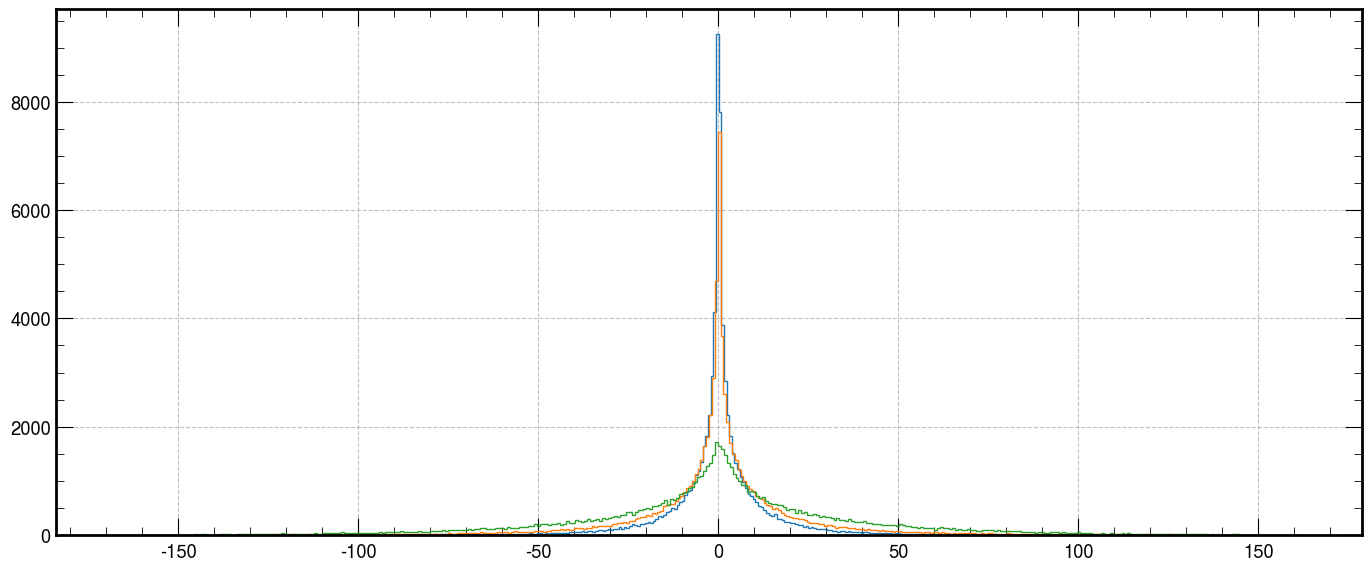

In [8]:
plt.hist(g_all_particles['zenith_diff'], bins=400, histtype='step');
plt.hist(g_all_minus_n['zenith_diff'], bins=400, histtype='step');
plt.hist(g_only_mu['zenith_diff'], bins=400, histtype='step');

Text(1, 0, 'True $E_\\nu$ (GeV)')

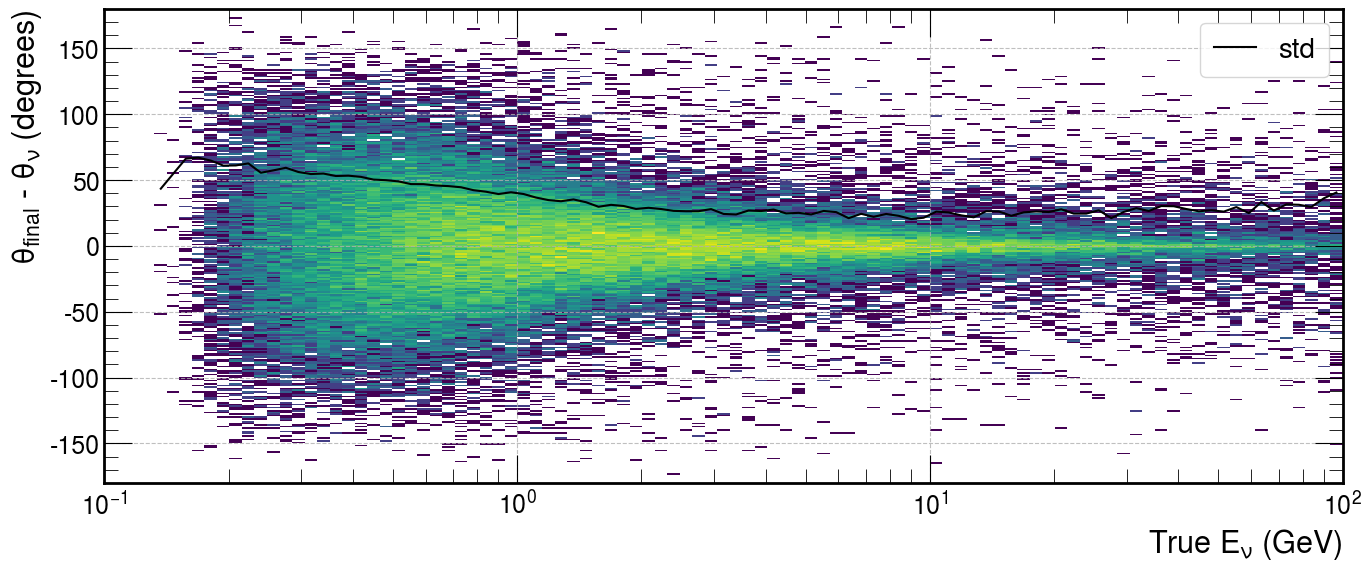

In [22]:
def plot_zenith_vs_energy_2d(df:pl.DataFrame, binsx, binsy, varx='enu_truth', vary='zenith_diff', ylabel=['final',r'\nu'], **kwargs):
    plt.figure(figsize=(14,6))
    plt.hist2d(df[varx], df[vary], bins=[binsx,binsy], norm='log', **kwargs);
    plt.xscale('log')
    from scipy.stats import binned_statistic
    std, _, _ = binned_statistic(df[varx], df[vary], 'std', binsx)

    plt.plot(0.5*(binsx[:-1] + binsx[1:]), std, color='k', label='std')
    plt.tick_params(which='both',labelsize=18)
    plt.tick_params(which='major',size=20)
    plt.tick_params(which='minor',size=10)
    plt.ylabel(fr'$\theta_{{{ylabel[0]}}}$ - $\theta_{{{ylabel[1]}}}$ (degrees)', fontsize=22)
    # plt.colorbar(pad=0.01)
    legend = plt.legend(loc='upper right', fontsize=20)
binsx = np.logspace(-1,2,100)
binsy = np.linspace(-180,180,300)
plot_zenith_vs_energy_2d(longest_mu, binsx, binsy)
plt.xlabel(r'True $E_\nu$ (GeV)', fontsize=22)

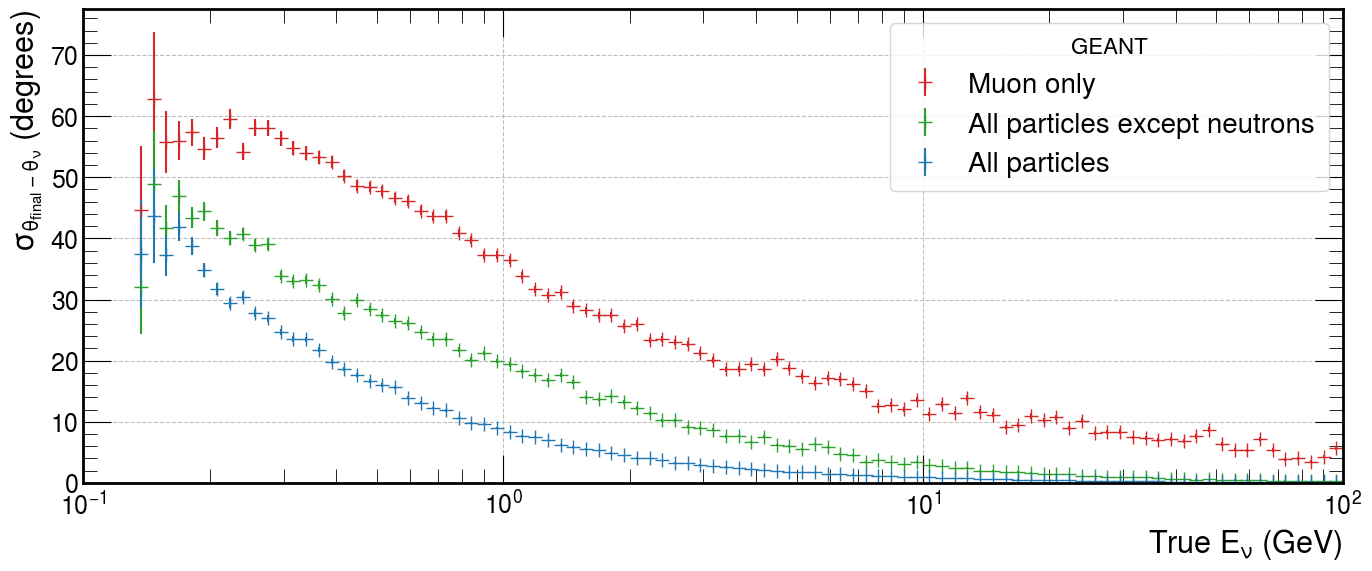

In [27]:
from scipy.stats import binned_statistic
def plot_zenith_vs_energy(df:pl.DataFrame, binsx, varx='enu_truth', vary='zenith_diff', fmt = '+', plot_n_events=False, **kwargs):
    std, _, _ = binned_statistic(df[varx], df[vary], 'std', binsx)
    counts, _, _ = binned_statistic(df[varx], df[vary], 'count', binsx)
    yerr = [s/np.sqrt(2*c-2) if c>1 else 0 for s,c in zip(std,counts)]
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    ax.errorbar(bins_center, std, yerr=yerr, fmt=fmt, **kwargs)
    ax.tick_params(which='both',labelsize=18)
    ax.tick_params(which='major',size=20)
    ax.tick_params(which='minor',size=10)
    ax.set_ylabel(r'$\sigma_{\theta_{final} - \theta_\nu}$ (degrees)', fontsize=22)
    ax.set_xscale('log')
    # plt.axhline(20,ls='--',c='gray')
    legend = plt.legend(loc='upper right', fontsize=20)
    legend.set_title("GEANT")
    plt.xlim(0.1,100)
    if plot_n_events:
        ax2 = ax.twinx()
        ax2.hist(binsx[:-1], binsx, weights=counts, alpha=0.2)
        ax2.set_ylabel(rf'# of events')
        ax2.grid(False)
        # ax2.set_yscale('log')
    plt.sca(ax)
    
binsx = np.logspace(-1,2,100)
binsy = np.linspace(-180,180,300)
# plot_zenith_vs_energy(longest_mu, binsx, markersize=10, label='Longest track', color='k', plot_n_events=False)#j, fmt='o')
# plt.figure(figsize=(6*1.5,5*1.5))
plot_zenith_vs_energy(g_only_mu, binsx,  markersize=10, label='Muon only', color='C3', plot_n_events=False)
plot_zenith_vs_energy(g_all_minus_n, binsx,  markersize=10, label='All particles except neutrons', color='C2')
plot_zenith_vs_energy(g_all_particles, binsx, markersize=10, label='All particles')#j, fmt='o')
plt.xlabel(r'True $E_\nu$ (GeV)', fontsize=22)
plt.ylim(bottom=0)
plt.savefig("angular_reco_geant.png", format='png', bbox_inches="tight", dpi=200)

Text(0, 1, '$\\theta_{\\mu}$')

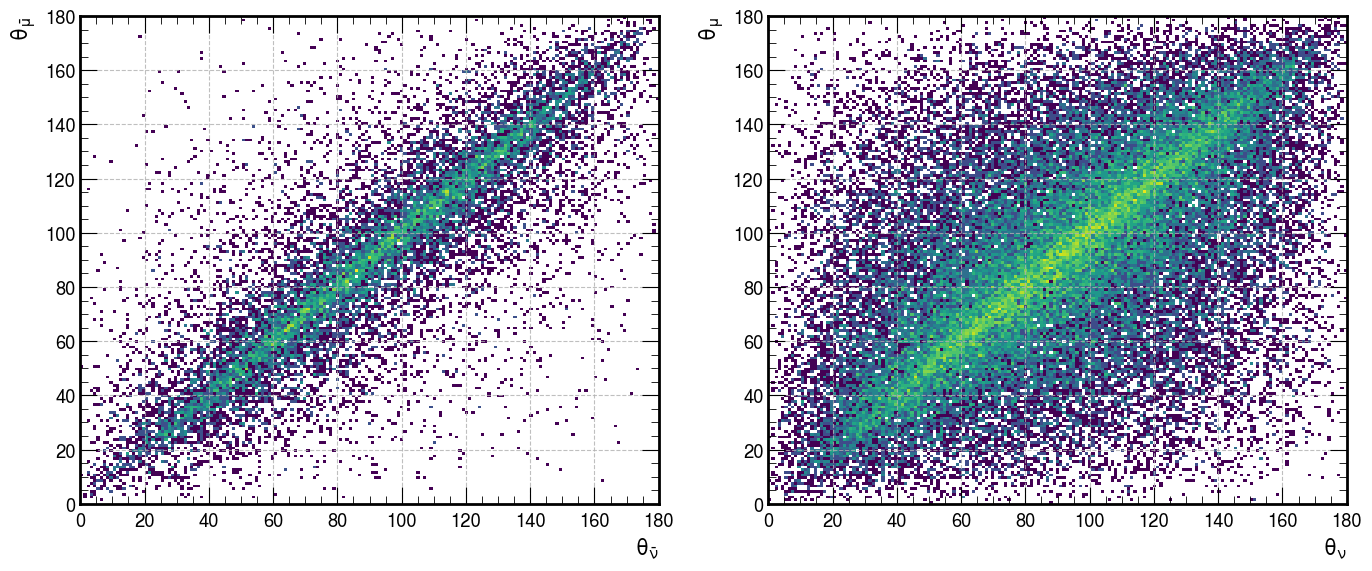

In [10]:
fig, axs = plt.subplots(1,2)
dftest = g_only_mu.filter(pl.col('nuPDG_truth')==-14)
binsa=np.linspace(0,180,180)
axs[0].hist2d(dftest['zenith_truth'], dftest['zenith_final'], bins=[binsa,binsa], norm='log');
dftest = g_only_mu.filter(pl.col('nuPDG_truth')==14)
axs[1].hist2d(dftest['zenith_truth'], dftest['zenith_final'], bins=[binsa,binsa], norm='log');
axs[0].set_xlabel(r'$\theta_\bar{\nu}$')
axs[0].set_ylabel(r'$\theta_\bar{\mu}$')
axs[1].set_xlabel(r'$\theta_{\nu}$')
axs[1].set_ylabel(r'$\theta_{\mu}$')

['subrun', 'event']


['subrun', 'event']
['subrun', 'event']
['subrun', 'event']


(0.1, 100)

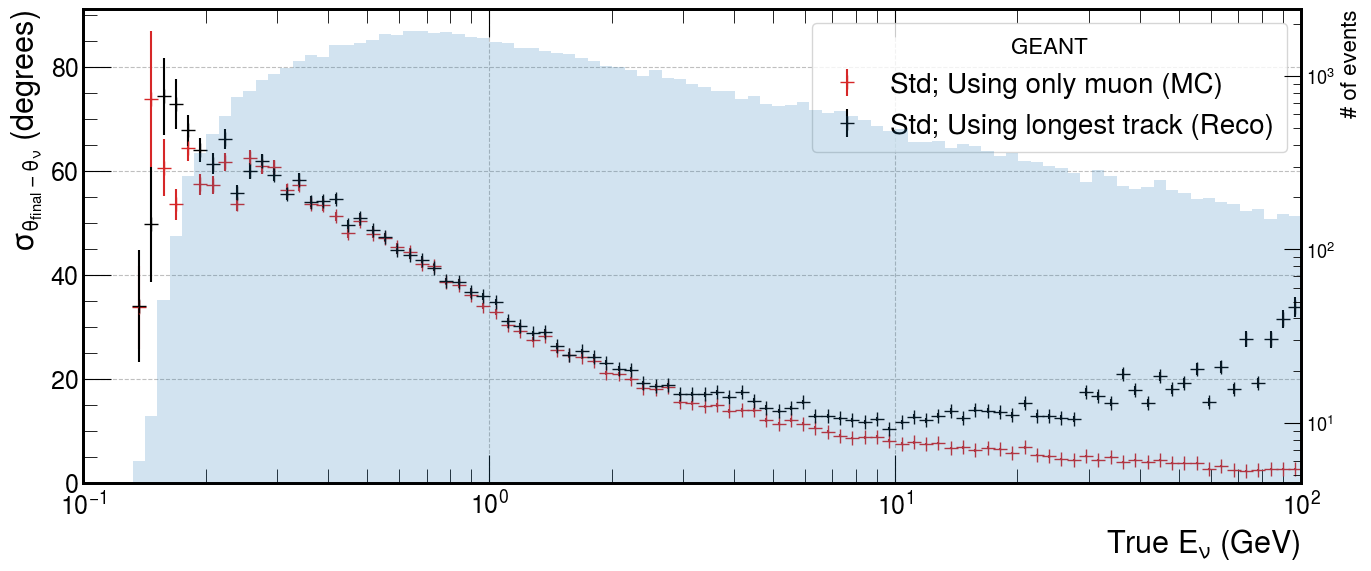

In [16]:
def get_longest_track(df:pl.DataFrame):
        df = df.filter(
                True                
                # ~(pl.col('pdg_geant').abs().is_in([22,211,2212]))
                # (pl.col('pdg_geant').abs().is_in([13]))
        )
        df = df.sort('trklen_pandoraTrack', descending=True).filter(
                (pl.col('nuPDG_truth').abs()==14 ) & (pl.col('ccnc_truth')==0)
        ).group_by(selection_events()).agg(
                pl.all().first(),
                zenith_diff = (pl.col('zenith_reco').first() - pl.col('zenith_truth').first())
        )
        return df

geant_longest_particle = geant_nu_f.filter(
    (pl.col('pdg_geant') != 22) & (pl.col('pdg_geant').abs() != 111)& (pl.col('pdg_geant').abs() != 2112)
    # (pl.col('pdg_geant').abs()==13) | (pl.col('pdg_geant').abs()==2212) | (pl.col('pdg_geant').abs()==211)
).sort('pathlen_drifted_geant', descending=True).group_by(selection_events()).agg(
    pl.all().first(),
    zenith_final = (pl.col('Py_geant').first()/pl.col('P_geant').first()).arccos()*180/np.pi,
).with_columns(
    zenith_diff = pl.col('zenith_final')- pl.col('zenith_truth')
)

longest_mu = get_longest_track(df.filter(pl.col('pfp_parentID')==-1))
longest_actual_mu = get_longest_track(df.filter(pl.col('pdg_geant').abs()==13).filter(pl.col('pfp_parentID')==-1))
longest_not_shower = get_longest_track(df.filter((pl.col('pdg_geant')!=22) & (pl.col('pdg_geant')!=111)).filter(pl.col('pfp_parentID')==-1))

binsx = np.logspace(-1,2,100)
binsy = np.linspace(-180,180,300)
plot_zenith_vs_energy(g_only_mu, binsx,  markersize=10, label='Std; Using only muon (MC)', color='C3')
plot_zenith_vs_energy(longest_mu, binsx, markersize=10, label='Std; Using longest track (Reco)', color='k', plot_n_events=True)#j, fmt='o')
# plot_zenith_vs_energy(geant_longest_particle, binsx, markersize=10, label='Std; Using longest g4 particle', color='b')#j, fmt='o')
plt.xlabel(r'True $E_\nu$ (GeV)', fontsize=22)
plt.ylim(bottom=0)
plt.xlim(0.1,100)

(0.1, 100)

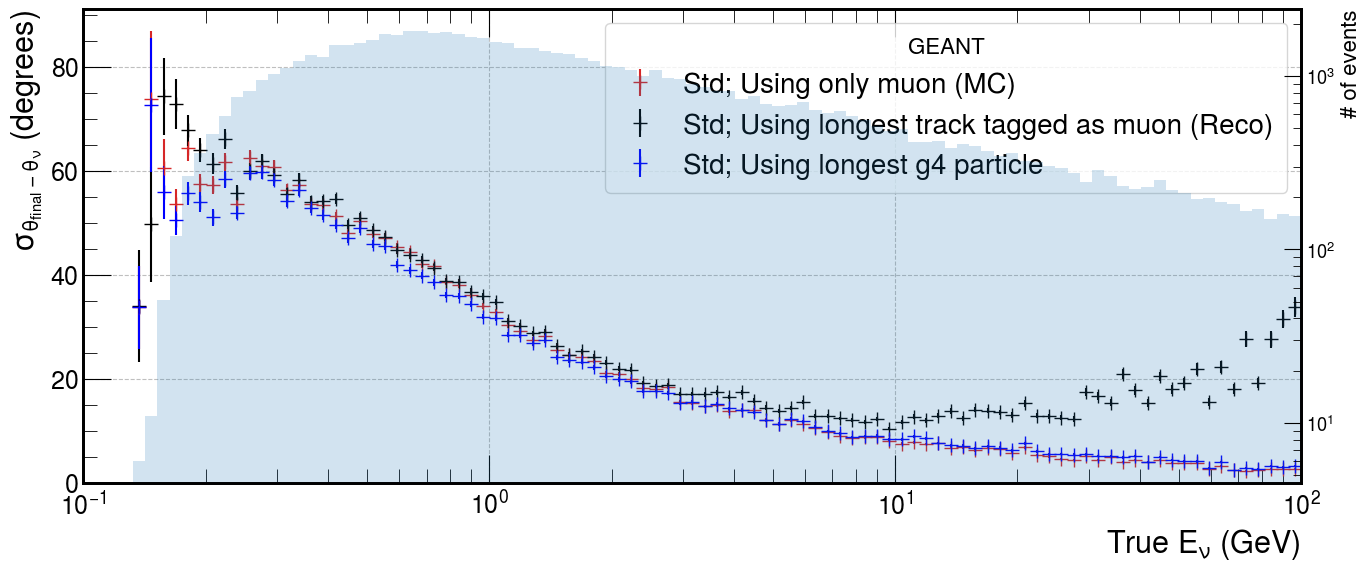

In [17]:

plot_zenith_vs_energy(g_only_mu, binsx,  markersize=10, label='Std; Using only muon (MC)', color='C3')
plot_zenith_vs_energy(longest_mu, binsx, markersize=10, label='Std; Using longest track tagged as muon (Reco)', color='k', plot_n_events=True)#j, fmt='o')
plot_zenith_vs_energy(geant_longest_particle, binsx, markersize=10, label='Std; Using longest g4 particle', color='b')#j, fmt='o')
plt.ylim(bottom=0)
plt.xlabel(r'True $E_\nu$ (GeV)', fontsize=22)
plt.xlim(0.1,100)

['subrun', 'event']


subrun,event,trkId_pandoraTrack,trkke_pandoraTrack_x,trkke_pandoraTrack_y,trkke_pandoraTrack_z,trkrange_pandoraTrack_x,trkrange_pandoraTrack_y,trkrange_pandoraTrack_z,trkidtruth_pandoraTrack_x,trkidtruth_pandoraTrack_y,trkidtruth_pandoraTrack_z,trkorigin_pandoraTrack_x,trkorigin_pandoraTrack_y,trkorigin_pandoraTrack_z,trkpdgtruth_pandoraTrack_x,trkpdgtruth_pandoraTrack_y,trkpdgtruth_pandoraTrack_z,trkefftruth_pandoraTrack_x,trkefftruth_pandoraTrack_y,trkefftruth_pandoraTrack_z,trkpurtruth_pandoraTrack_x,trkpurtruth_pandoraTrack_y,trkpurtruth_pandoraTrack_z,trkpitchc_pandoraTrack_x,trkpitchc_pandoraTrack_y,trkpitchc_pandoraTrack_z,ntrkhits_pandoraTrack_x,ntrkhits_pandoraTrack_y,ntrkhits_pandoraTrack_z,trkstartx_pandoraTrack,trkstarty_pandoraTrack,trkstartz_pandoraTrack,trkstartd_pandoraTrack,trkendx_pandoraTrack,trkendy_pandoraTrack,trkendz_pandoraTrack,…,StartPx_drifted_geant,StartPy_drifted_geant,StartPz_drifted_geant,EndPointx_drifted_geant,EndPointy_drifted_geant,EndPointz_drifted_geant,EndT_drifted_geant,EndE_drifted_geant,EndP_drifted_geant,EndPx_drifted_geant,EndPy_drifted_geant,EndPz_drifted_geant,NumberDaughters_geant,Mother_geant,MergedId_geant,origin_geant,MCTruthIndex_geant,process_primary_geant,processname_geant,nuPDG_truth,ccnc_truth,nuvtxx_truth,nuvtxy_truth,nuvtxz_truth,enu_truth,nu_dcosx_truth,nu_dcosy_truth,nu_dcosz_truth,mode_truth,nuvtxx,nuvtxy,nuvtxz,track_angle_diff,zenith_reco,zenith_geant,zenith_truth,zenith_g_diff
i32,i32,i16,f32,f32,f32,f32,f32,f32,i32,i32,i32,i16,i16,i16,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,i32,i32,str,i32,i32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32,f32,f32,f32,f32,f32
0,5,0,107.680252,94.48278,100.041451,26.238886,22.673147,25.713943,1,1,1,1,1,1,13,13,13,1.013033,0.977041,0.99857,0.86397,0.905212,0.87025,0.475943,1.859977,0.634315,57,17,44,92.810913,-494.948029,347.923615,112.880722,87.033142,-510.148956,368.49353,…,-0.034085,-0.095861,0.129803,87.469231,-510.648956,368.288208,0.0,0.105658,0.0,-0.0,-0.0,0.0,11,0,0,1,0,1,"""primary""",14,0,93.203362,-494.554657,347.81604,0.54219,-0.575745,-0.490022,-0.654527,1,92.434731,-494.371521,348.114655,1.858674,123.947662,125.537926,119.342003,-1.590263
0,17,0,1476.505859,1362.933228,1683.381348,798.527405,797.377136,798.670837,1,1,1,1,1,1,-13,-13,-13,0.82932,0.669581,0.897384,0.991805,0.984413,0.992147,0.604862,2.619869,0.818714,935,607,765,155.92749,334.692078,462.401917,207.448563,-282.336212,-214.59436,85.35984,…,-1.007004,-1.352386,-0.83937,-282.565826,-214.51918,85.484177,0.0,0.105658,0.0,-0.0,-0.0,-0.0,3,0,0,1,0,1,"""primary""",-14,0,157.162109,335.776215,463.188873,2.323587,-0.225394,-0.867213,-0.444007,0,155.881409,334.553711,462.027222,0.246288,135.744415,135.891251,150.136353,-0.146835
10000,9,0,117.321777,163.764099,158.595657,51.28706,58.682327,58.356632,1,1,1,1,1,1,13,13,13,0.812201,0.951772,0.76339,0.982571,0.962692,0.982997,2.491044,0.984192,1.175372,36,82,56,-148.562973,87.05957,609.682556,214.81308,-195.824615,109.19957,583.333984,…,-0.201786,0.12051,-0.099395,-196.397141,108.895012,583.240173,0.0,0.105658,0.0,-0.0,0.0,-0.0,9,0,0,1,0,1,"""primary""",14,0,-146.141998,85.295692,611.106201,0.87394,0.819466,0.565628,0.092461,0,-145.663986,85.398987,610.710999,3.194327,61.691433,61.819878,55.554119,-0.128445
10000,17,0,156.254059,148.560089,140.387177,51.84483,51.649464,47.22456,1,1,1,1,1,1,13,13,13,0.984673,0.989543,1.000558,0.867743,0.847481,0.881779,0.615607,0.562058,0.489983,82,92,98,-136.197159,200.829193,1163.825195,227.178894,-125.231369,205.771652,1113.096436,…,0.043928,0.02874,-0.224108,-125.356209,206.354279,1113.137207,0.0,0.105658,0.0,0.0,0.0,-0.0,16,0,0,1,0,1,"""primary""",14,0,-136.277878,200.599869,1163.688232,0.657729,-0.031016,0.440081,-0.897428,1,-136.143326,200.834015,1163.296997,0.862981,83.66864,82.82711,63.890968,0.84153
10001,13,0,76.474419,133.89386,133.731461,23.041578,42.142269,42.735992

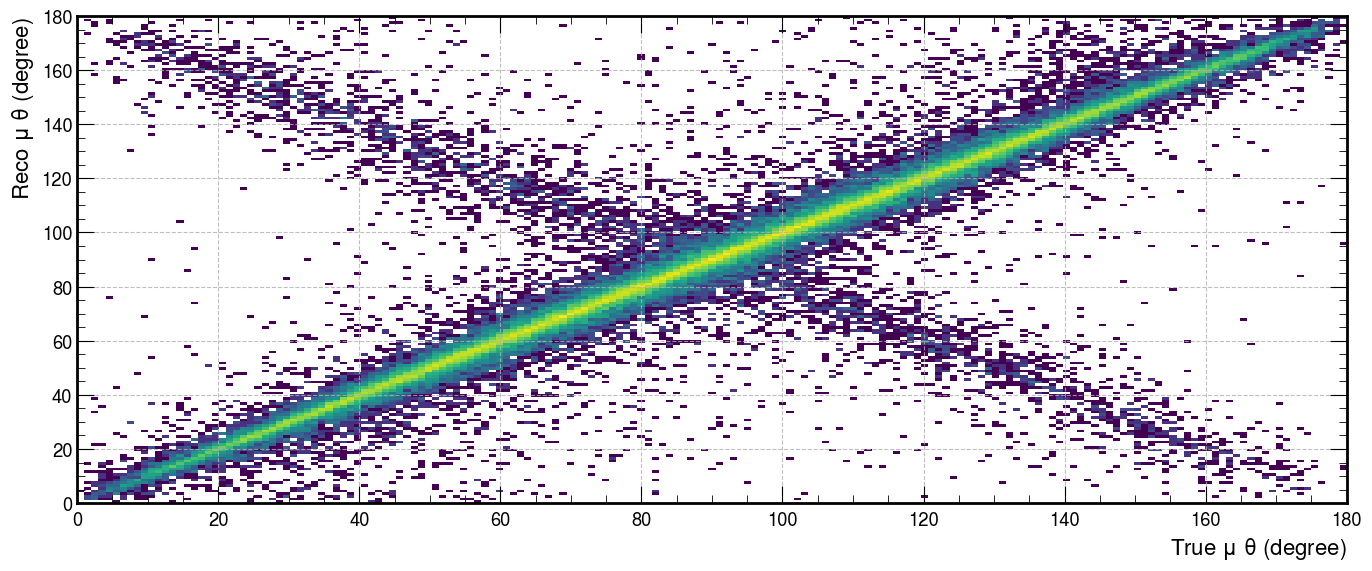

<Figure size 1400x600 with 0 Axes>

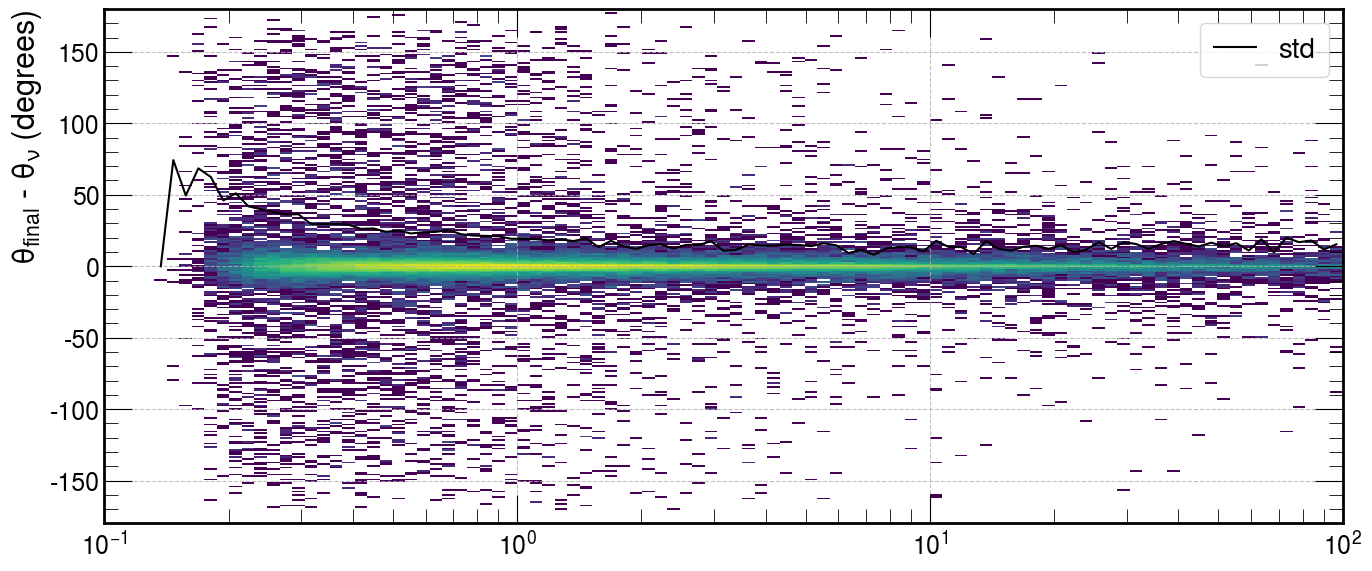

In [23]:
test_mu = df.filter(
    (pl.col('nuPDG_truth').abs()==14 ) & (pl.col('ccnc_truth')==0)
).filter(
    (pl.col('pdg_geant').abs()==13) & (pl.col('Mother_geant')==0)
).group_by(selection_events()).agg(
    pl.all().first()
)
# test_mu = test_mu.filter(pl.col('track_angle_diff').abs()<90)
plt.hist2d(test_mu['zenith_geant'], test_mu['zenith_reco'], bins=[binsa,binsa], norm='log');
plt.xlabel(r'True $\mu$ $\theta$ (degree)')
plt.ylabel(r'Reco $\mu$ $\theta$ (degree)')
plt.figure()
plot_zenith_vs_energy_2d(test_mu, binsx, binsy, varx='enu_truth', vary='zenith_g_diff')
# plt.ylim(0,80)

(25.7, 72.0)

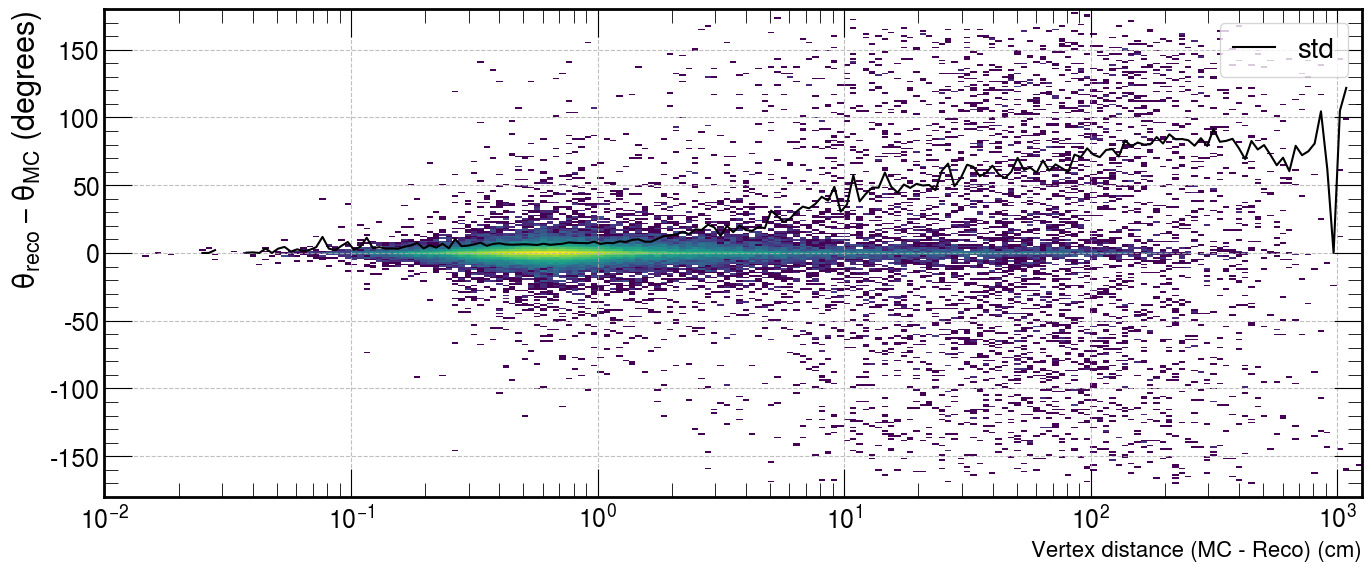

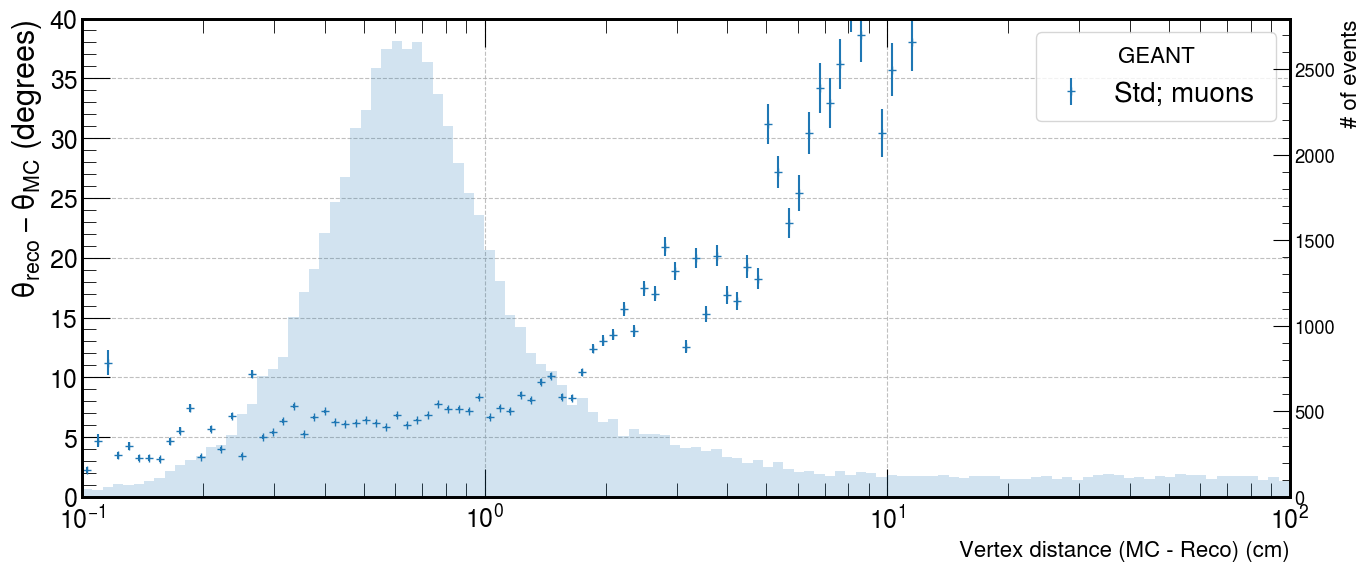

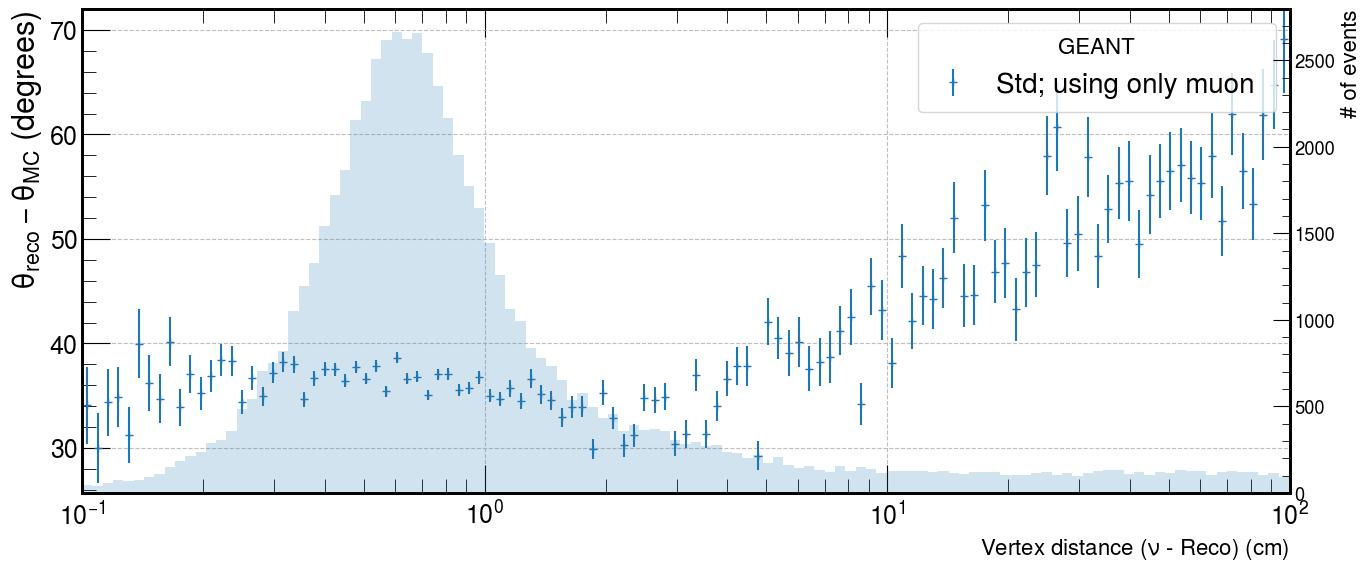

In [30]:
test_vtx = test_mu.with_columns(
    vtxdist = (
        (pl.col('nuvtxx_truth') - pl.col('nuvtxx'))**2 +
        (pl.col('nuvtxy_truth') - pl.col('nuvtxy'))**2 +
        (pl.col('nuvtxz_truth') - pl.col('nuvtxz'))**2
    ).sqrt(),
    zenith_diff = (pl.col('zenith_reco')- pl.col('zenith_truth'))
)
binsdist = np.logspace(-2,3.1,200)
plot_zenith_vs_energy_2d(test_vtx, binsdist, binsy, varx='vtxdist', vary='zenith_g_diff')
plt.xscale('log')
plt.xlabel('Vertex distance (MC - Reco) (cm)')
plt.ylabel(r'$\theta_{reco} - \theta_{MC}$ (degrees)')
plt.figure()
plot_zenith_vs_energy(test_vtx, binsdist, varx='vtxdist', vary='zenith_g_diff', label='Std; muons ' , plot_n_events=True)
plt.xlabel('Vertex distance (MC - Reco) (cm)')
plt.ylabel(r'$\theta_{reco} - \theta_{MC}$ (degrees)')
plt.ylim(0,40)
plt.figure()
plot_zenith_vs_energy(test_vtx, binsdist, varx='vtxdist', vary='zenith_diff', label='Std; using only muon ' , plot_n_events=True)
plt.xlabel(r'Vertex distance ($\nu$ - Reco) (cm)')
plt.ylabel(r'$\theta_{reco} - \theta_{MC}$ (degrees)')
plt.ylim(25.7, 72)

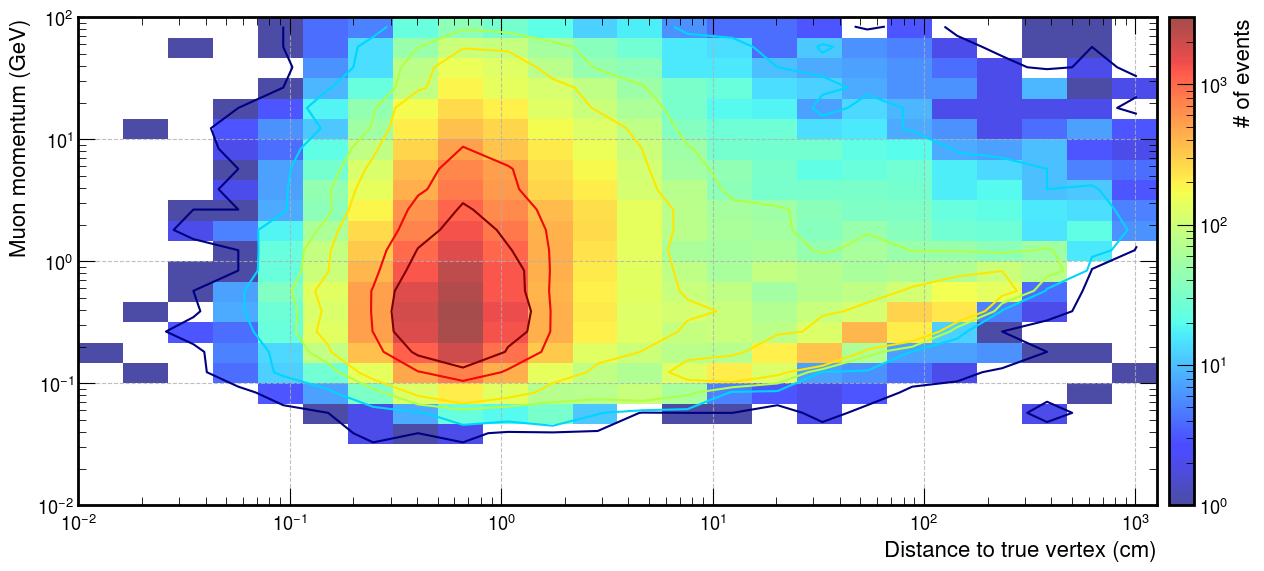

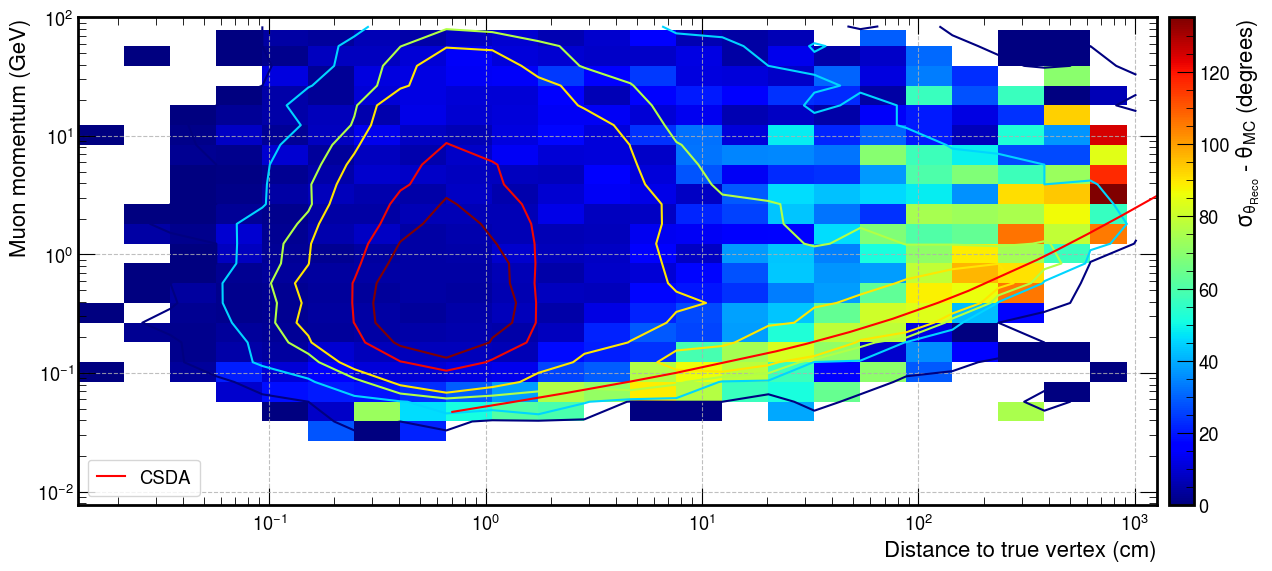

In [20]:
from scipy.stats import binned_statistic_2d
# test_vtx = test_vtx.filter(
#     pl.col('track_angle_diff').abs()<120
# )
x = test_vtx['vtxdist']
y = test_vtx['P_geant']
binse=np.logspace(-2,2,25)
binsdist = np.logspace(-2,3.1,25)
h, xedge, yedge, img = plt.hist2d(x, y, bins=[binsdist, binse], norm='log', cmap='jet', alpha=0.7)
grid = h.transpose()
midpoints = (xedge[1:] + xedge[:-1])/2, (yedge[1:]+yedge[:-1])/2
# cs = plt.contourf(*midpoints, grid, levels=2, extend='max', alpha=0.5, zorder=100)
plt.contour(*midpoints, grid, levels=[1,10,50,100,500,1000], norm='log', cmap='jet')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Muon momentum (GeV)')
plt.xlabel('Distance to true vertex (cm)')
c=plt.colorbar(img, pad=0.01)
c.set_label(r'# of events')

plt.figure()
ret = binned_statistic_2d(x, y, test_vtx['zenith_g_diff'], statistic='std', bins=[binsdist, binse])
stds = ret.statistic
q=plt.pcolormesh(ret.x_edge[:-1], ret.y_edge[:-1], stds.T, cmap='jet')
plt.contour(*midpoints, grid, levels=[1,10,50,100,500,1000], norm='log', cmap='jet')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Muon momentum (GeV)')
plt.xlabel('Distance to true vertex (cm)')
c=plt.colorbar(q,pad=0.01)
c.set_label(r'$\sigma_{\theta_{Reco}}$ - $\theta_{MC}$ (degrees)')
Range_grampercm = np.array([9.833E-1, 1.786E0, 3.321E0,
       6.598E0, 1.058E1, 3.084E1, 4.250E1, 6.732E1, 1.063E2, 1.725E2,
       2.385E2, 4.934E2, 6.163E2, 8.552E2, 1.202E3, 1.758E3, 2.297E3,
       4.359E3, 5.354E3, 7.298E3, 1.013E4, 1.469E4, 1.910E4, 3.558E4,
       4.326E4, 5.768E4, 7.734E4, 1.060E5, 1.307E5])
KE_MeV = np.array([ 10, 14,
       20, 30, 40, 80, 100, 140, 200, 300, 400, 800, 1000, 1400, 2000, 3000,
       4000, 8000, 10000, 14000, 20000, 30000, 40000, 80000, 100000, 140000,
       200000, 300000, 400000 ])


KE_GeV = KE_MeV/1e3
mu_mom = np.sqrt(KE_GeV*(KE_GeV+2*0.1056))
mu_range = Range_grampercm/1.4
plt.plot(mu_range, mu_mom, c='red', label='CSDA')
plt.ylim(top=binse[-1])
plt.xlim(right=binsdist[-1])
plt.legend(loc='lower left')

In [12]:
binsp = np.logspace(-2,2,50)
plot_zenith_vs_energy(test_mu, binsp, varx='P_geant', vary='zenith_g_diff', label='Std; muons')
plot_zenith_vs_energy(test_mu.filter(pl.col('track_angle_diff').abs()<120), binsp, varx='P_geant', vary='zenith_g_diff', label='Std; muons (filter wrong direction)')

plt.ylim(bottom=0)
# plot_zenith_vs_energy(longest_actual_mu, binsx, vary='zenith_g_diff')

NameError: name 'plot_zenith_vs_energy' is not defined

['subrun', 'event']
['subrun', 'event']
['subrun', 'event']


/tmp/ipykernel_17718/2955216987.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  primary_mu = geant_nu_f.filter(pl.col('pdg_geant').abs()==13).sort('TrackId_geant').groupby(selection_events()).agg(


NameError: name 'plot_zenith_vs_energy' is not defined

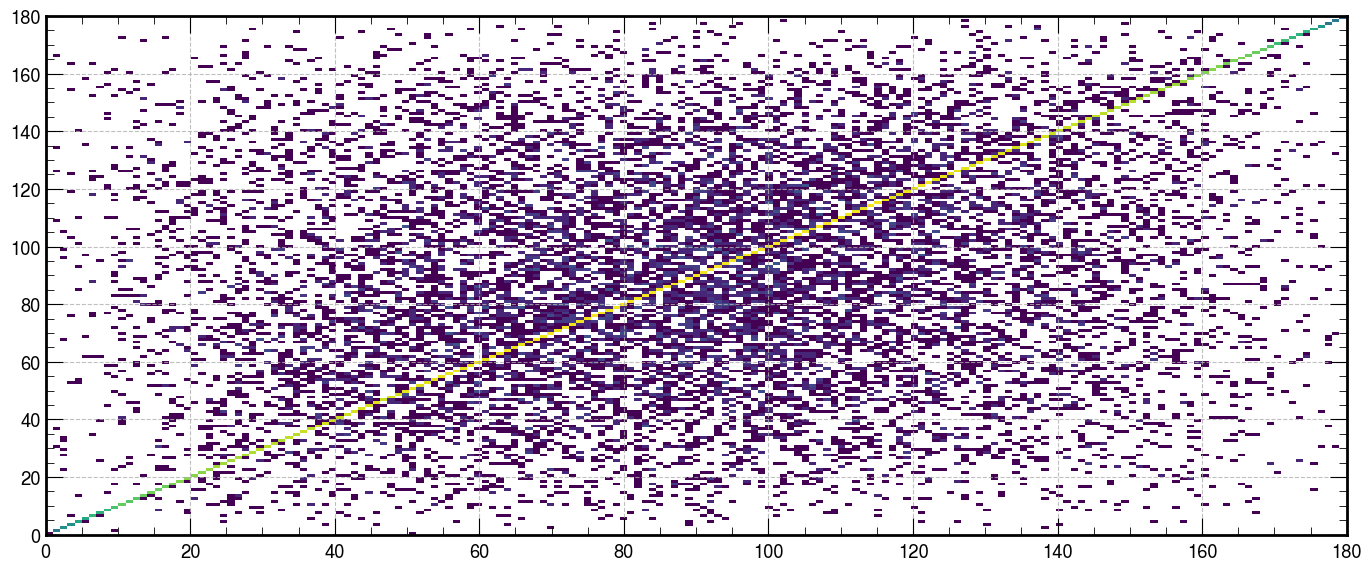

<Figure size 1400x600 with 0 Axes>

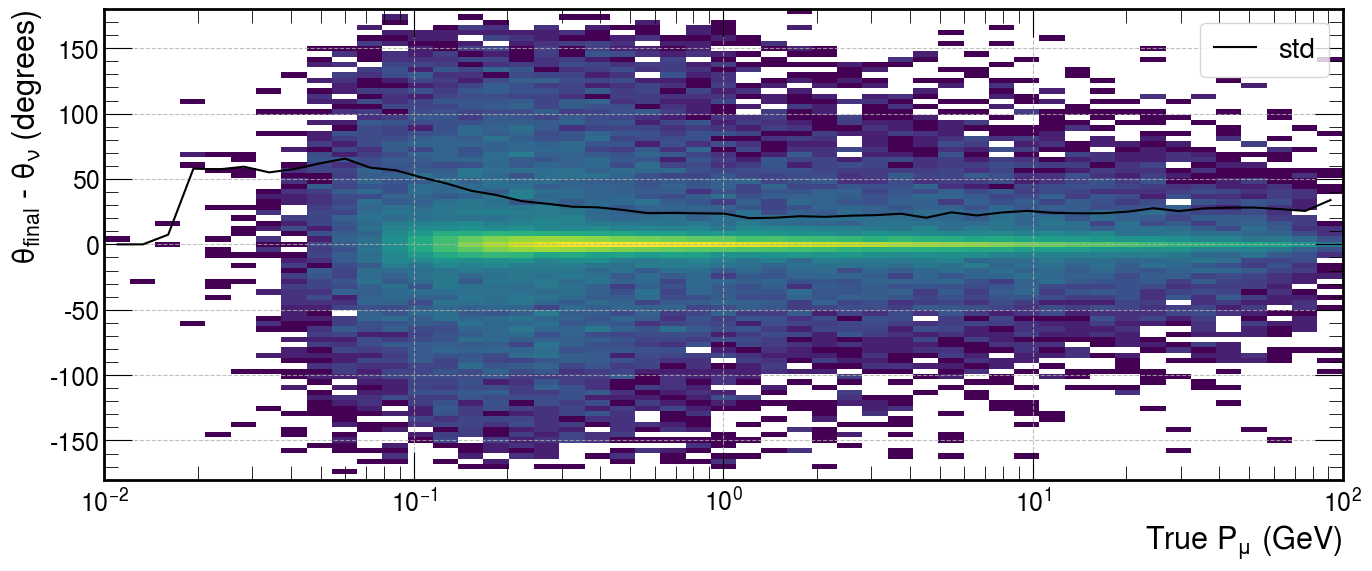

<Figure size 1400x600 with 0 Axes>

In [13]:
primary_mu = geant_nu_f.filter(pl.col('pdg_geant').abs()==13).sort('TrackId_geant').groupby(selection_events()).agg(
    pl.all().first(),
    zenith_final = (pl.col('Py_geant').first()/pl.col('P_geant').first()).arccos()*180/np.pi,
).with_columns(
    zenith_diff = pl.col('zenith_final')- pl.col('zenith_truth')
)

test_longest = longest_mu.join(primary_mu, on=selection_events(), how='inner', suffix='_true')
test_longest = test_longest.with_columns(
    zenith_ultimate_diff = pl.col('zenith_reco') - pl.col('zenith_final')
)

test_longest_actual_mu = longest_actual_mu.join(primary_mu, on=selection_events(), how='inner', suffix='_true')
test_longest_actual_mu = test_longest_actual_mu.with_columns(
    zenith_ultimate_diff = pl.col('zenith_reco') - pl.col('zenith_final')
)

plt.hist2d(test_longest['zenith_final'], test_longest['zenith_geant'], bins=[binsa,binsa], norm='log');
plt.figure()
binsx = np.logspace(-2,2,50)
binsy = np.linspace(-180,180,90)
plot_zenith_vs_energy_2d(test_longest, binsx, binsy, varx = 'P_geant_true', vary='zenith_ultimate_diff')
plt.xlabel(r'True $P_\mu$ (GeV)', fontsize=22)
plt.figure()
plot_zenith_vs_energy(test_longest, binsx, varx = 'P_geant', vary='zenith_g_diff', label='std; longest (using MC particle from track)')
plot_zenith_vs_energy(test_longest, binsx, varx = 'P_geant_true', vary='zenith_ultimate_diff', label=r'std; longest (using true $\mu$ information)', plot_n_events=True)
plot_zenith_vs_energy(test_longest_actual_mu, binsx, varx = 'P_geant_true', vary='zenith_ultimate_diff', label=r'std; longest (actual $\mu$)')
plt.xlabel(r'True $P$ (GeV)', fontsize=22);
plt.ylim(-1,100)

In [ ]:
geant_longest_particle = geant_nu_f.filter(
    (pl.col('pdg_geant') != 22) & (pl.col('pdg_geant').abs() != 111)& (pl.col('pdg_geant').abs() != 2112)
    # (pl.col('pdg_geant').abs()==13) | (pl.col('pdg_geant').abs()==2212) | (pl.col('pdg_geant').abs()==211)
).sort('pathlen_drifted_geant', descending=True).group_by(selection_events()).agg(
    pl.all().first(),
    zenith_final = (pl.col('Py_geant').first()/pl.col('P_geant').first()).arccos()*180/np.pi,
).with_columns(
    zenith_diff = pl.col('zenith_final')- pl.col('zenith_truth')
)
def pdgname(x):
    return particle.Particle.from_pdgid(x)
geant_longest_particle.with_columns(
    total = pl.col('pdg_geant').count()
).group_by('pdg_geant').agg(
    count = pl.col('pdg_geant').count(),
    pdg = pl.col('pdg_geant').first().map_elements(lambda x: pdgname(x)),
    total = pl.col('total').first()
).with_columns(
    relative = pl.col('count')/pl.col('total')*100
)



pdg_geant,count,pdg,total,relative
i32,u32,object,u32,f64
3112,2,Sigma-,74699,0.002677
321,96,K+,74699,0.128516
130,1,K(L)0,74699,0.001339
3122,4,Lambda,74699,0.005355
-13,15864,mu+,74699,21.237232
211,1644,pi+,74699,2.200833
-12,1,nu(e)~,74699,0.001339
-2212,2,p~,74699,0.002677
2212,3303,p,74699,4.421746


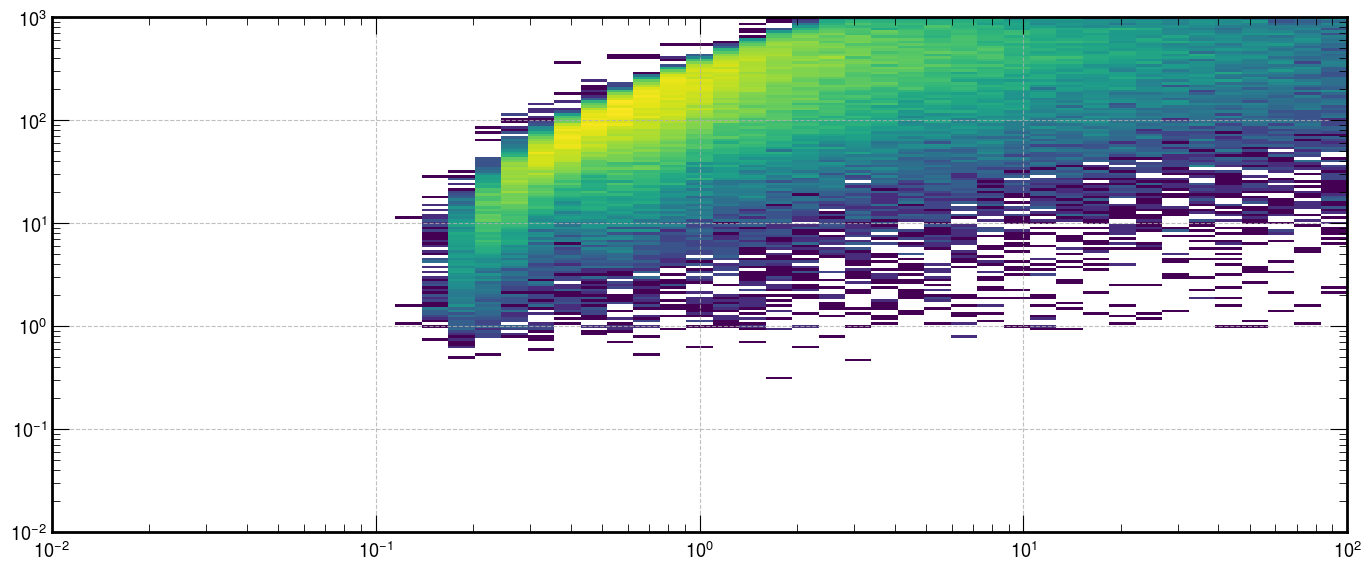

In [20]:
test = longest_mu#.filter(
#     check_fiducial('pandoraTrack')
# )
plt.hist2d(test['enu_truth'], test['trklen_pandoraTrack'], bins=[binsx, np.logspace(-2,3,200)], norm='log');
plt.xscale('log')
plt.yscale('log')